In [69]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DATA_FOLDER = os.path.join("out")
OUTPUT_FOLDER = os.path.join("out", "plots")

def get_dataset_file(dataset, timestamp = "latest"):
    # Get all CSV files in the folder
    csv_folder = os.path.join(BASE_DATA_FOLDER, dataset)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        return pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")

def output_fig(filename, dataset, cloud):
    output_folder = os.path.join(OUTPUT_FOLDER, dataset, cloud)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plt.savefig(os.path.join(output_folder, filename), dpi=300, bbox_inches='tight')

In [70]:
# Read the file and put into pandas dataframe
DATASET, CLOUD = "alcoy", "alcoy"
df = get_dataset_file(DATASET, "latest")

# Convert times to milliseconds
df['mean'] = df['mean'] * 1000
df['stdev'] = df['stdev'] * 1000

Loading latest file: out/alcoy/alcoy-2025-01-21-12:28:22.csv


In [71]:
# Plot styling and octree types list and palette
plt.style.use('seaborn')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.axisbelow': True
})

octree_types = df['octree'].unique()
palette = sns.color_palette("Set2", len(octree_types))
color_dict = dict(zip(octree_types, palette))

In [72]:
# Some aux. functions for plot information
def add_execution_details(searches, repeats, points, fig):
    execution_details = [
        f"• {searches:,} searches × {repeats:,} repeats",
        f"• Dataset: {DATASET} ({points:,} points)",
        f"• Point Cloud: {CLOUD}"
    ]
    fig.text(0.10, 0.935,
            '\n'.join(execution_details),
            fontsize=10,
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)

def add_title_subtitle(title, subtitle, fig):
    fig.text(0.10, 0.98, 
            title, 
            fontsize=16, 
            fontweight='bold', 
            ha='left', 
            va='top')

    fig.text(0.10, 0.955,
            subtitle,
            fontsize=12,
            fontstyle='italic',
            color='#404040',
            ha='left',
            va='top')

def add_octree_types_legend(legend_handles, legend_labels, fig):
    fig.legend(
        legend_handles,
        [f"{octree}, {encoder}, {point_type}" for octree, encoder, point_type in legend_labels],
        title="Octree type parameters",
        loc="upper right",
        bbox_to_anchor=(0.9, 1),
        fontsize=10
    )

In [73]:
OCTREE_TYPE_PARAMS = ['octree', 'encoder', 'point_type']
# Get unique octree parameters (i.e. the templated variables)
parameter_combinations = df[OCTREE_TYPE_PARAMS].drop_duplicates().sort_values(
    by=['octree', 'encoder', 'point_type'], ascending=[True, True, True]
)

# Create color palette and mapping
palette = sns.color_palette("Paired", len(parameter_combinations))
color_dict = {
    (row['octree'], row['encoder'], row['point_type']): color
    for row, color in zip(parameter_combinations.to_dict(orient='records'), palette)
}
print(parameter_combinations)

      octree           encoder point_type
96    Linear  HilbertEncoder3D   Lpoint64
32    Linear   MortonEncoder3D   Lpoint64
128  Pointer  HilbertEncoder3D   Lpoint64
64   Pointer   MortonEncoder3D   Lpoint64
0    Pointer         Unencoded   Lpoint64


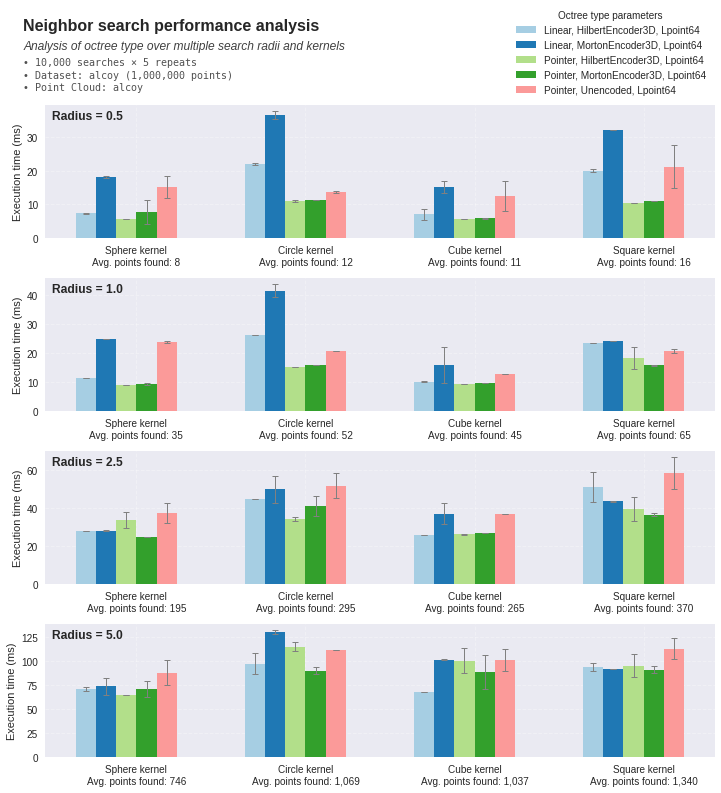

In [74]:
def octree_performance_by_radii_and_kernel(df, operation, operation_name):
    # Filter the dataset the specified operation
    operation_df = df[df['operation'] == operation]
   
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)), 
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(parameter_combinations)
    group_gap = 0.5
   
    legend_handles, legend_labels = [], []

    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
       
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = [] 
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(parameter_combinations.iterrows()):
                octree, encoder, point_type = params['octree'], params['encoder'], params['point_type']
                octree_data = kernel_data[
                    (kernel_data['octree'] == octree) & 
                    (kernel_data['encoder'] == encoder) & 
                    (kernel_data['point_type'] == point_type)
                ]

                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, 
                                color=color_dict[(octree, encoder, point_type)])
                ax.errorbar(x_pos, means[0], stdevs[0], 
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                
                if radius_idx == 0 and (octree, encoder, point_type) not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append((octree, encoder, point_type))

        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.01, 0.96, f'Radius = {radius}', 
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')
    
    add_octree_types_legend(legend_handles, legend_labels, fig)

    add_title_subtitle(f"{operation_name} performance analysis", f"Analysis of octree type over multiple search radii and kernels", fig)

    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(nsearches, nrepeats, npoints, fig)

    return fig

fig = octree_performance_by_radii_and_kernel(df, 'neighSearch', 'Neighbor search')
output_fig('neighbor_perf.png', DATASET, CLOUD)

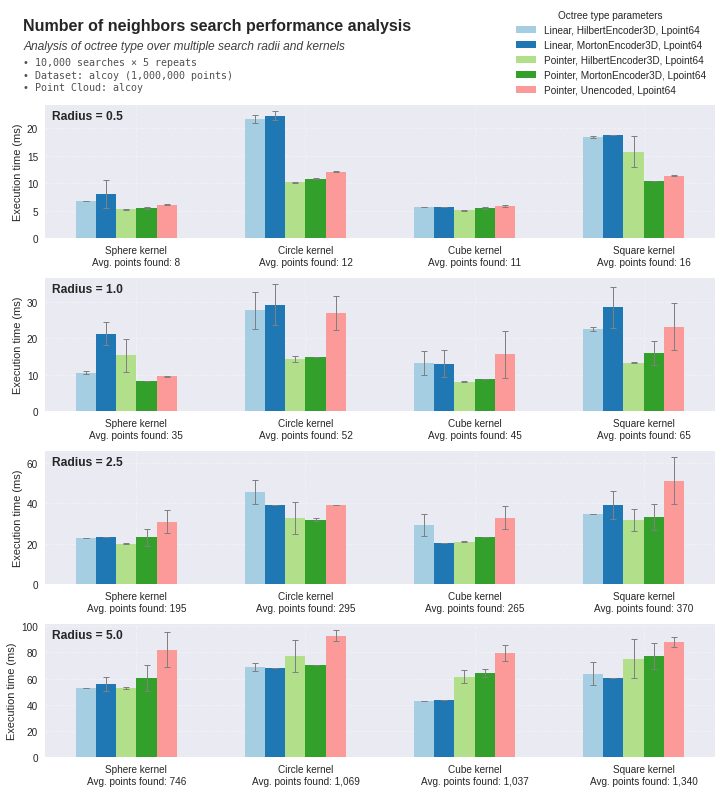

In [75]:
fig = octree_performance_by_radii_and_kernel(df, 'numNeighSearch', 'Number of neighbors search')
output_fig('num_neighbor_perf.png', DATASET, CLOUD)